In [1]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from Pneumonia_predictor import PneumoniaPredictorCNN, PneumoniaDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

In [2]:

model_name = '6_smaller_img_bs32_lr0.0001_epoch15_img_size224x224'
batch_size = 5

output_dir = Path('output/model/')
model_path = Path(output_dir/f'{model_name}_final.pth')
model_config = Path(output_dir/f'{model_name}_config.yaml')

with open(model_config, 'r') as f:
    config = yaml.safe_load(f)

seed = config['seed']
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


model_params  = {'image_size':config['image_size'],
                'in_channels':config['in_channels'], 
                'conv_defs':config['conv_layers'], 
                'fc_defs':config['fc_layers'],
                'fc_dropout':config['fc_dropout'],
                'fc_batch_norm':config['fc_batch_norm']
                }


model =PneumoniaPredictorCNN(**model_params)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


PneumoniaPredictorCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [3]:
# laod test data and show  some images

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

test_data_df = pd.read_csv(f'data/test_data.csv')
normal_df = test_data_df[test_data_df['encoded_label'] == 0]
pneumonia_df = test_data_df[test_data_df['encoded_label'] == 1]

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_dataset = PneumoniaDataset(test_data_df, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataiter = iter(test_loader)



map_labels = {0: 'Normal', 1: 'Pneumonia'}


In [14]:
# i want to get the file name of the image from 
test_dataset = PneumoniaDataset(test_data_df, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataiter = iter(test_loader)

In [15]:
file_names_lst = []
for batch in dataiter:
    with torch.no_grad():
        images, labels, file_names =batch

        
        outputs = model(images)           # (B,1) raw logits
        logits  = outputs.squeeze(1)      # -> (B,)

        # apply sigmoid & threshold at 0.5:
        probs   = torch.sigmoid(logits)   # (B,) in [0,1]
        preds   = (probs > 0.5).long()    # (B,) in {0,1}

        model.zero_grad()
        ig = IntegratedGradients(model)
        attr_ig = ig.attribute(images, target=0, n_steps = 100 )

        for i in range(images.shape[0]):
            curr_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
            curr_attr = attr_ig[i].cpu().detach().numpy().transpose(1, 2, 0)
        
            fig, ax = plt.subplots(figsize=(6,6))
            viz.visualize_image_attr(
                attr = curr_attr,
                original_image=curr_image,
                method="blended_heat_map",
                sign="all",
                show_colorbar=True,
                plt_fig_axis=(fig, ax),
                use_pyplot=False
            )
            # save the image
            file_name_path = f'{file_names[i]}_pred_{preds[i].item()}_prob_{probs[i].item():.3f}_ig.png'


            try:
                fig.savefig(file_name_path)
            except Exception as e:
                print(f"Error saving figure {file_name_path}: {e}")
            plt.close(fig)

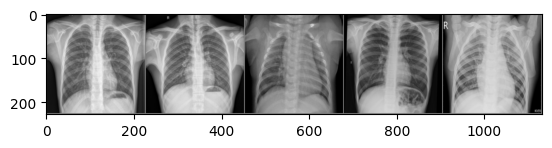

GroundTruth:  Normal Normal Normal Normal Normal


In [ ]:
# iterate through the test data
norm_images, norm_labels = next(normiter)
norm_labels = norm_labels.numpy()
imshow(torchvision.utils.make_grid(norm_images))
print('GroundTruth: ', ' '.join('%5s' % map_labels[i] for i in norm_labels))


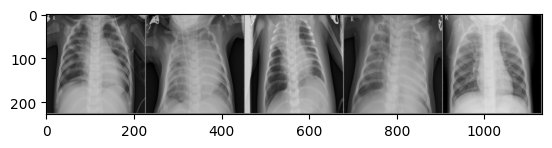

GroundTruth:  Pneumonia Pneumonia Pneumonia Pneumonia Pneumonia


In [ ]:
# iterate through the test data
pneu_images, pneu_labels = next(pneumiter)
pneu_labels = pneu_labels.numpy()
imshow(torchvision.utils.make_grid(pneu_images))
print('GroundTruth: ', ' '.join('%5s' % map_labels[i] for i in pneu_labels))


In [ ]:
with torch.no_grad():
    images = norm_images
    # make labels floats if you didn't already:
    labels = norm_labels

    outputs = model(images)           # (B,1) raw logits
    logits  = outputs.squeeze(1)      # -> (B,)

    # apply sigmoid & threshold at 0.5:
    probs   = torch.sigmoid(logits)   # (B,) in [0,1]
    preds   = (probs > 0.5).long()    # (B,) in {0,1}
    print(f'Normal: predictions: {preds} | probabilities: {[round(p, 3) for p in probs.tolist()]}')

    images = pneu_images
    labels = pneu_labels
    outputs = model(images)           # (B,1) raw logits
    logits  = outputs.squeeze(1)      # -> (B,)

    probs  = torch.sigmoid(logits)   # (B,) in [0,1]
    preds  = (probs > 0.5).long()    # (B,) in {0,1}
    print(f'Pneumonia: predictions: {preds} | probabilities: {[round(p, 3) for p in probs.tolist()]}')


Normal: predictions: tensor([0, 0, 0, 1, 1]) | probabilities: [0.003, 0.0, 0.101, 0.918, 0.967]
Pneumonia: predictions: tensor([1, 1, 1, 1, 1]) | probabilities: [0.99, 0.989, 0.988, 0.992, 0.991]
